##Libraries

In [1]:
import pickle as pkl
import builtins

In [ ]:
#update torch and torch vision
!pip install -q torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch

In [ ]:
!pip install fastai==1.0.61

In [6]:
import fastai
print("fastai version: ", fastai.__version__) #1.0.61

fastai version:  1.0.61


In [7]:
from fastai.basic_train import *
from fastai.vision.data import *
from fastai.vision.image import *
from fastai.vision.transform import *
from fastai.vision.models import *
from fastai.vision.learner import *
from fastai.vision import *

##Mounting Google Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Paths

In [9]:
output_path   = Path('/content/gdrive/My Drive/Colab Notebooks/Zindi/output')

In [10]:
train_path = output_path/'train_patchlets_nofilt_allbands'
# train_path = output_path/'train_patchlets_filt_13bands'

In [11]:
test_path  = output_path/'test_patchlets_nofilt_allbands'
# test_path  = output_path/'test_patchlets_filt_13bands'

In [12]:
test_fields_path  = output_path/'test_patchlets_nofilt_allbands_fieldids'

###Create custom ItemList and LabelList classes to define data loading and display

In [21]:
class SegmentationPklLabelList(SegmentationLabelList):
    def open(self, fn):
        #print(fn)
        x = pkl.load(builtins.open(str(fn),'rb'))[None,...].astype(np.float32)
        #print(x.shape)
        return ImageSegment(torch.tensor(x))

In [22]:
class SegmentationPklList(SegmentationItemList):
    _label_cls,_square_show_res = SegmentationPklLabelList,False
    
    def open(self, fn):
        #print(fn)
        x = pkl.load(builtins.open(str(fn),'rb'))
        #print(x.shape)
        #x = x.transpose([0,3,1,2]).reshape([-1, 64, 64]).astype(np.float32)  #,x.shape[1],x.shape[2]]).astype(np.float32)
        x = x[:, :, :, :13]
        x = x.transpose([0,3,1,2]).reshape([-1, x.shape[1], x.shape[2]]).astype(np.float32) 

        #print(x.shape)
        return Image(torch.tensor(x))
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): Image(torch.clamp(x.data[0:3,:,:]*3.5,0,1)).show(ax=ax, y=y, alpha=0.4,**kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

In [23]:
classes=['No Data',        
         'Cotton', 
         'Vineyard',                 
         'Grass',          
         'Lucern',         
         'Maize',          
         'Pecan',          
         'Vacant']

In [24]:
def valid_patch(fn, i=6):
    return f'patch_{i}' in str(fn)

def get_mask(fn):
    return str(fn).replace('feat','targ')

def exclude_masks(fn):
    return not('targ' in str(fn.name))

In [25]:
bs = 32

In [ ]:
src = (SegmentationPklList.from_folder(train_path, extensions=['.pkl'], recurse=True, convert_mode='L')
      .filter_by_func(exclude_masks)
      .split_by_rand_pct(0.1, seed=42)
      #.split_by_valid_func(valid_patch)
      .label_from_func(get_mask, classes=classes))
src

In [27]:
stats_data = src.databunch(bs=128)

In [31]:
x,y = stats_data.one_batch()

In [34]:
means = x.mean(dim=[0,2,3])
stds = x.std(dim=[0,2,3])

In [39]:
data = (src
        .databunch(bs=bs, num_workers = 0)
        .normalize(stats=(means,stds))
        )

View a batch

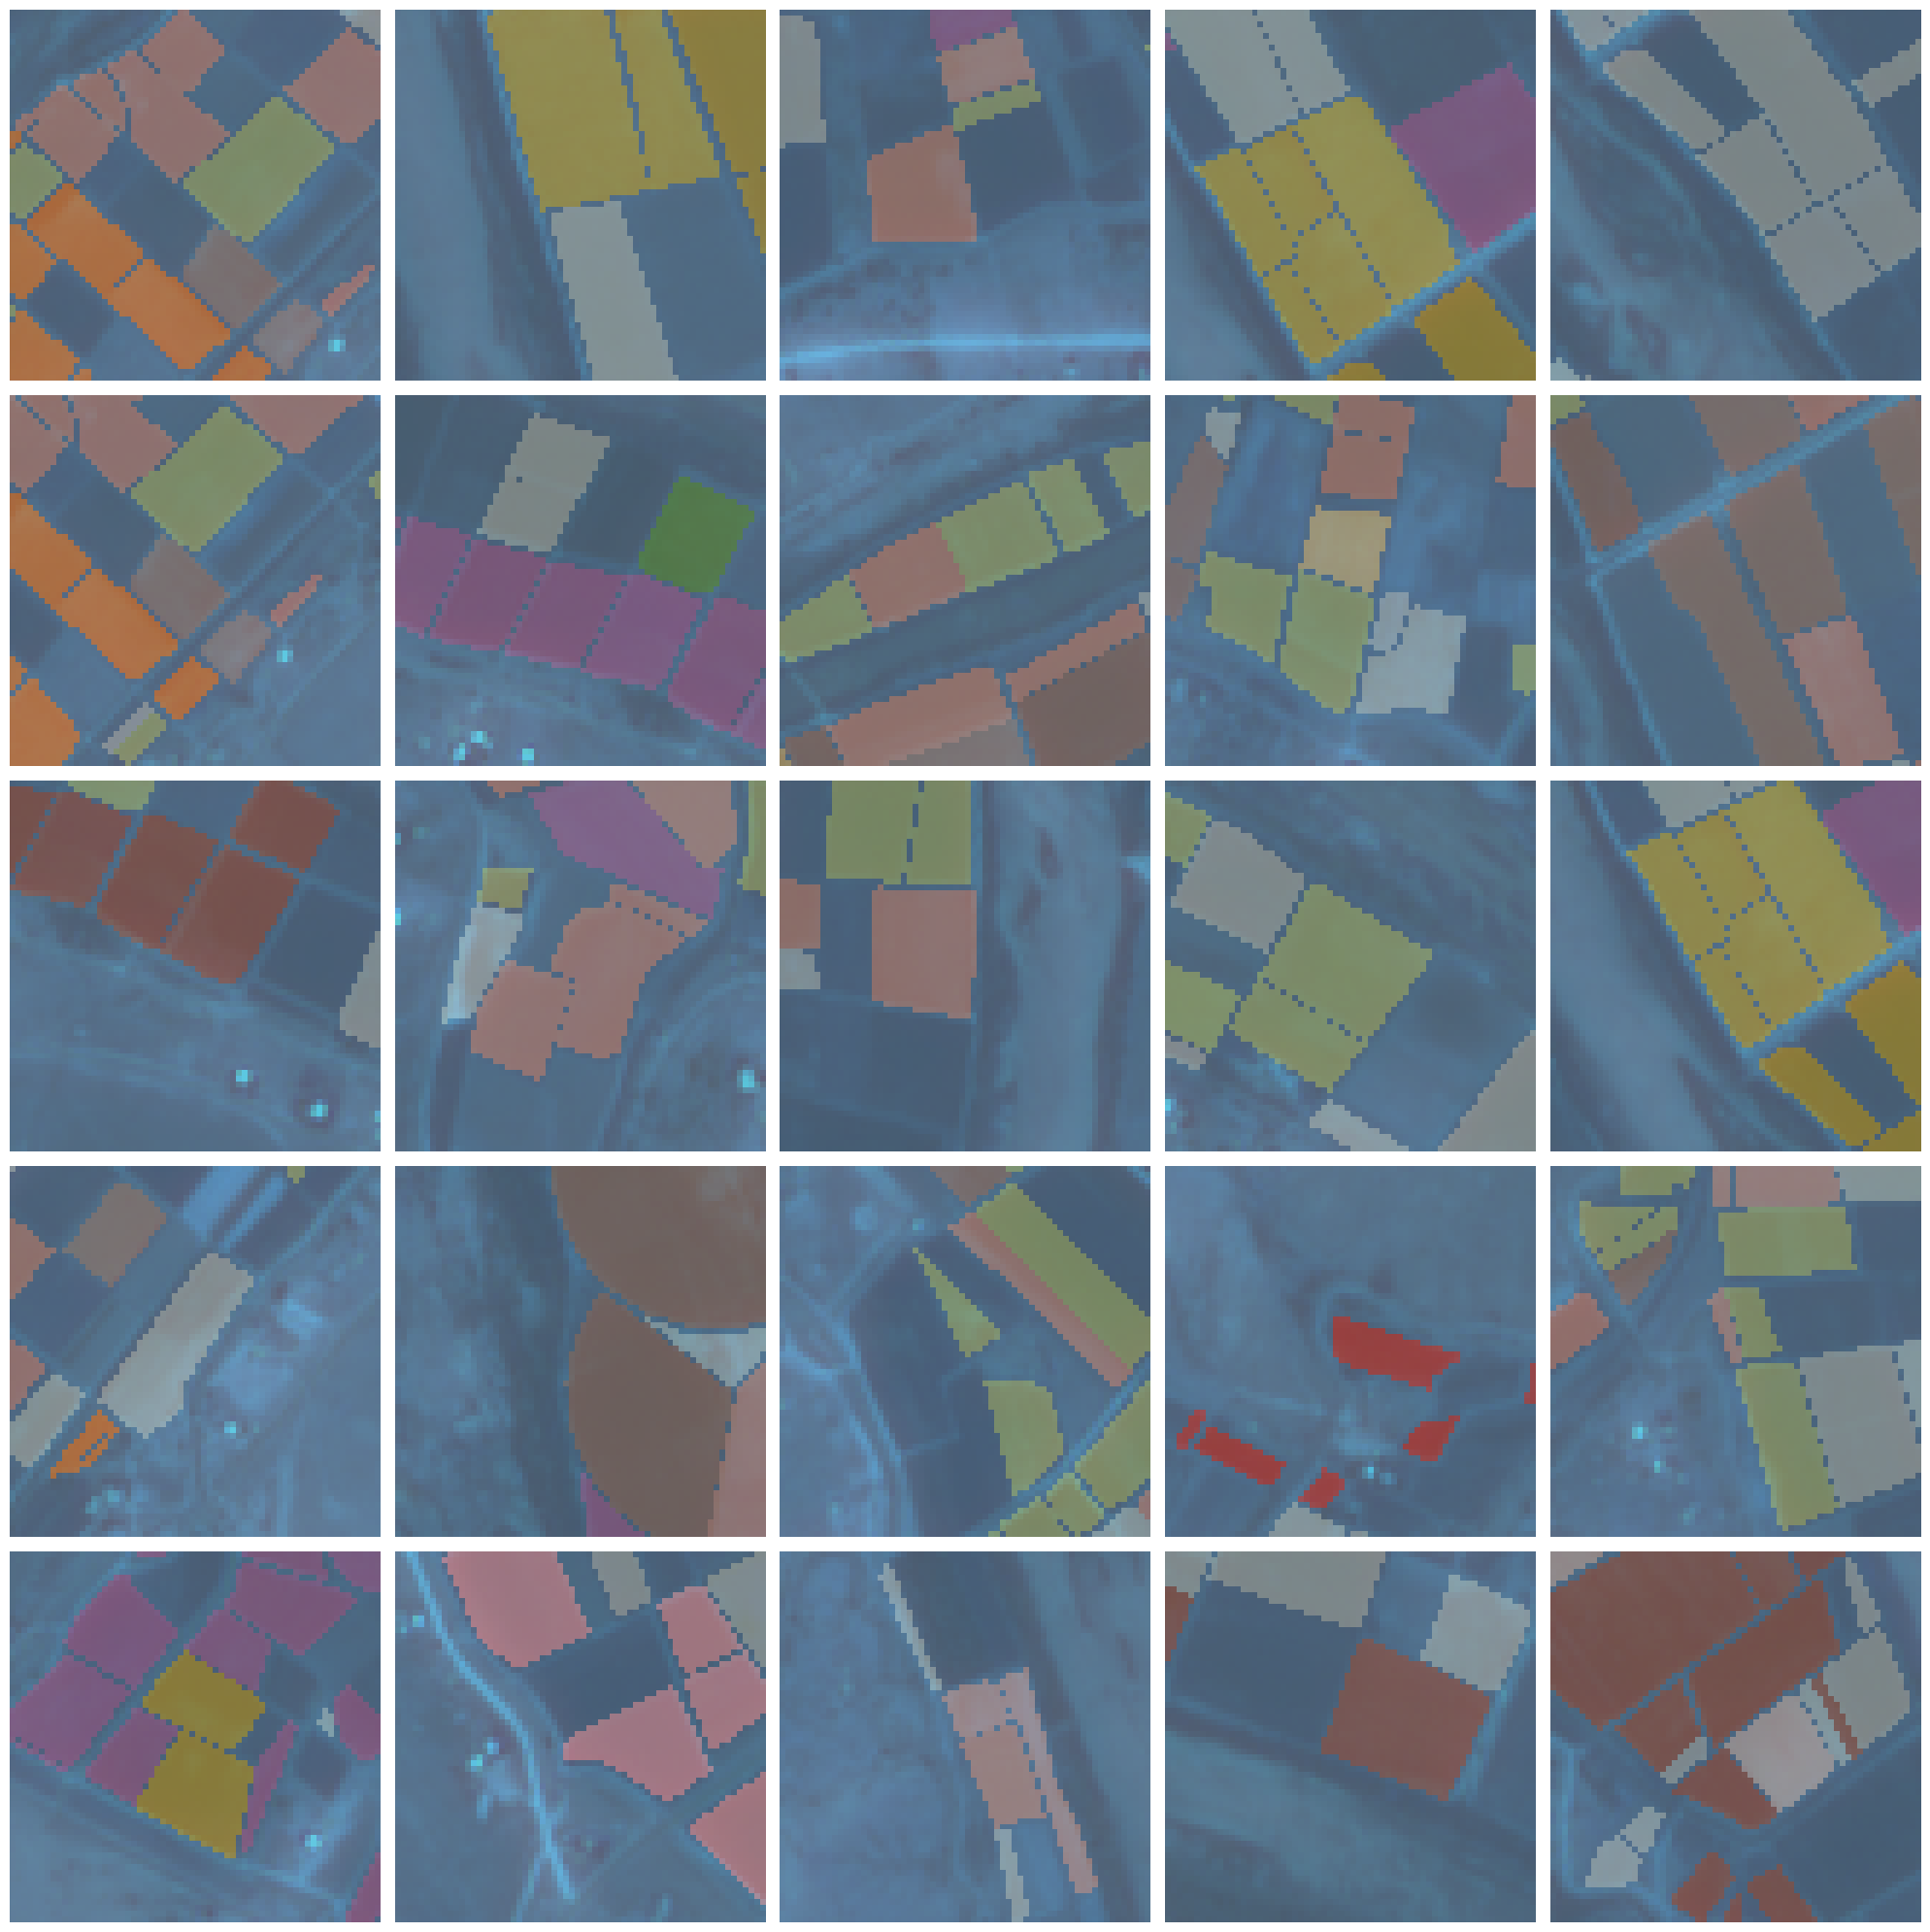

In [50]:
data.show_batch()

##Loss Functions

In [51]:
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [52]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, crit, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.crit = crit
    
    def forward(self, inputs, targets, reduction):
        loss = self.crit(inputs, targets)
        pt = torch.exp(-loss)
        F_loss = self.alpha * (1-pt)**self.gamma * loss

        if reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [53]:
def loss_fn(pred, targ):
    targ[targ==255] = 1
    return torch.nn.functional.cross_entropy(pred, targ.squeeze(1).type(torch.long))

##Create class-weighted focal loss

In [54]:
train_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Zindi/Farmpin_training.csv')

In [56]:
inv_freq = np.array(1/(train_df.crop_id.value_counts()/2051))
inv_freq

array([ 2.522755,  4.527594,  8.58159 ,  9.075221, 16.277778, 17.091667, 27.716216])

In [57]:
inv_freq = [0.,*inv_freq]
inv_freq

[0.0,
 2.5227552275522758,
 4.527593818984547,
 8.581589958158997,
 9.075221238938054,
 16.27777777777778,
 17.09166666666667,
 27.716216216216218]

In [58]:
inv_prop = torch.tensor(inv_freq/sum(inv_freq)).float().cuda()
inv_prop

tensor([0.0000, 0.0294, 0.0528, 0.1000, 0.1058, 0.1897, 0.1992, 0.3231],
       device='cuda:0')

In [59]:
#focal_loss = FocalLoss(crit=CrossEntropyLossFlat(axis=1,weight=inv_prop,ignore_index=0)) # ignore the no-data class
focal_loss = FocalLoss(crit=CrossEntropyFlat(axis=1,weight=inv_prop,ignore_index=0)) # For Fastaiv1

In [60]:
class myMixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = myMixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)

        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            
            new_lambd = torch.distributions.utils.broadcast_all(lambd[:,None,None,None], last_target)[0]
            
            #new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), new_lambd[:,None].float()], 1)
            new_target = torch.stack([last_target.float(), y1.float(), new_lambd.float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
            
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

In [61]:
from functools import partial

In [62]:
class myMixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) >= 5:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            lambd = target[:,2].contiguous().view(-1)
            d = (loss1 * lambd  + loss2 * (1-lambd)).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

In [63]:
def pixel_acc(inputs, targs):
    inputs = inputs.argmax(dim=1)[:,None,...]
    return (targs[targs!=0]==inputs[targs!=0]).float().mean()
    #return (targs==inputs).float().mean()

##Learner with Timm Backbone

###Timm

In [ ]:
!pip install timm==0.4.12

In [83]:
import timm

In [88]:
from fastai.layers import *

In [89]:
dummy_batch = torch.rand((32, 16*8, 64, 64))

In [90]:
class Encoder(nn.Module):
  def __init__(self, model_name = 'resnext50'):
    super().__init__()
    self.encoder = timm.create_model(model_name, features_only = True, pretrained = False, in_chans=16*8)

  def forward(self, x):
    return self.encoder(x)

In [91]:
enc = Encoder('resnet152')

In [92]:
for o in enc(dummy_batch):
  print(o.shape)

torch.Size([32, 64, 32, 32])
torch.Size([32, 256, 16, 16])
torch.Size([32, 512, 8, 8])
torch.Size([32, 1024, 4, 4])
torch.Size([32, 2048, 2, 2])


###Creating U-Net Model

In [93]:
from timm.models.layers import create_attn, get_attn

Some of the available timm attention models:


*   se
*   ese
*eca
*ceca
*cbam
*lcbam

In [94]:
class UnetBlock(Module):
  def __init__(self, in_channels, channels, out_channels, attn = None):
    self.conv1 = conv_layer(in_channels, channels)
    self.conv2 = conv_layer(channels, out_channels)
    self.attn_layer = attn(out_channels) if attn else noop

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.attn_layer(x)
    return x

In [95]:
def upsize(x,scale_factor=2):
    x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
    return x

In [96]:
def calc_hyperfeats1(d1, d2, d3, d4):
  hyperfeats = torch.cat((
      d1, 
      F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False),
      F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
      F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False)), 1)
  return hyperfeats

In [97]:
def calc_hyperfeats2(d1, d2, d3):
  hyperfeats = torch.cat((
      d1, 
      F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False),
      F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False)), 1)
  return hyperfeats

In [98]:
def calc_hyperfeats3(d1, d2):
  hyperfeats = torch.cat((
      d1, 
      F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False)), 1)
  return hyperfeats

In [99]:
class UnetPlusDecoder(nn.Module):
    def __init__(self,
                 num_channels=1,
                 num_class=1,
                 hypercol = False,
                 attn=None
                 ):
        super().__init__()
        self.hypercol = hypercol
        self.mix = nn.Parameter(torch.FloatTensor(5))
        self.mix.data.fill_(1)
 
        # Decoder
        self.decoder0_1 =  UnetBlock(64+256,32,64,attn)


        self.decoder1_1 = UnetBlock(256+512,32,64,attn)
        self.decoder0_2 =  UnetBlock(64+64+64,32,64,attn)


        self.decoder2_1 = UnetBlock(512+1024,64,128,attn)
        self.decoder1_2 = UnetBlock(256+64+128,64,128,attn)
        self.decoder0_3 = UnetBlock(64+64+64+128,64,128,attn)


        self.decoder3_1 = UnetBlock(1024+2048,128,256,attn)
        self.decoder2_2 = UnetBlock(512+128+256,128,256,attn)
        self.decoder1_3 = UnetBlock(256+64+128+256,128,256,attn)
        self.decoder0_4 = UnetBlock(64+64+64+128+256,128,256,attn)

        if hypercol:
          #self.logit1 = nn.Conv2d(512,num_class, kernel_size=1)
          self.logit1 = nn.Sequential(conv_layer(512, 128), conv_layer(128, 32), nn.Conv2d(32, num_class, kernel_size=1))
          #self.logit2 = nn.Conv2d(448,num_class, kernel_size=1)
          self.logit2 = nn.Sequential(conv_layer(448, 128), conv_layer(128, 32), nn.Conv2d(32, num_class, kernel_size=1))
          #self.logit3 = nn.Conv2d(384,num_class, kernel_size=1)
          self.logit3 = nn.Sequential(conv_layer(384, 128), conv_layer(128, 32), nn.Conv2d(32, num_class, kernel_size=1))
          #self.logit4 = nn.Conv2d(256,num_class, kernel_size=1)
          self.logit4 = nn.Sequential(conv_layer(256, 128), conv_layer(128, 32), nn.Conv2d(32, num_class, kernel_size=1))
        else:
          #self.logit1 = nn.Conv2d( 64,num_class, kernel_size=1)
          self.logit1 = nn.Sequential(conv_layer(64, 32), conv_layer(32, 16), nn.Conv2d(16, num_class, kernel_size=1))
          #self.logit2 = nn.Conv2d( 64,num_class, kernel_size=1)
          self.logit2 = nn.Sequential(conv_layer(64, 32), conv_layer(32, 16), nn.Conv2d(16, num_class, kernel_size=1))
          #self.logit3 = nn.Conv2d(128,num_class, kernel_size=1)
          self.logit3 = nn.Sequential(conv_layer(128, 32), conv_layer(32, 16), nn.Conv2d(16, num_class, kernel_size=1))
          #self.logit4 = nn.Conv2d(256,num_class, kernel_size=1)
          self.logit4 = nn.Sequential(conv_layer(256, 32), conv_layer(32, 16), nn.Conv2d(16, num_class, kernel_size=1))

          
    def forward(self, feats, x):
        _,_, H,W = x.shape
        e1, e2, e3, e4, e5 = feats

        #print("e1: ", e1.shape) # [32, 64, 32, 32]
        #print("e2: ", e2.shape) # [32, 256, 16, 16]
        #print("e3: ", e3.shape) # [32, 512, 8, 8]
        #print("e4: ", e4.shape) # [32, 1024, 4, 4]
        #print("e5: ", e5.shape) # [32, 2048, 2, 2]

        x0_1 = self.decoder0_1(torch.cat([e1, upsize(e2)], 1))
        # print("x0_1: ", x0_1.shape) # x0_1:  torch.Size([32, 64, 32, 32])

        x1_1 = self.decoder1_1(torch.cat([e2, upsize(e3)],1))
        # print("x1_1: ", x1_1.shape) # x1_1:  torch.Size([32, 64, 16, 16])

        x0_2 = self.decoder0_2(torch.cat([e1, x0_1, upsize(x1_1)], 1))
        # print("x0_2: ", x0_2.shape) # x0_2:  torch.Size([32, 64, 32, 32])

        x2_1 = self.decoder2_1(torch.cat([e3, upsize(e4)], 1))
        #print("x2_1: ", x2_1.shape) # x2_1:  torch.Size([32, 128, 8, 8])

        x1_2 = self.decoder1_2(torch.cat([e2, x1_1, upsize(x2_1)], 1))
        #print("x1_2: ", x1_2.shape) # x1_2:  torch.Size([32, 128, 16, 16])

        x0_3 = self.decoder0_3(torch.cat([e1, x0_1, x0_2,  upsize(x1_2)], 1))
        #print("x0_3: ", x0_3.shape) # x0_3:  torch.Size([32, 128, 32, 32])

        x3_1 = self.decoder3_1(torch.cat([e4, upsize(e5)], 1))
        #print("x3_1: ", x3_1.shape) # x3_1:  torch.Size([32, 256, 4, 4])

        x2_2 = self.decoder2_2(torch.cat([e3, x2_1, upsize(x3_1)], 1))
        #print("x2_2: ", x2_2.shape) # x2_2:  torch.Size([32, 256, 8, 8])

        x1_3 = self.decoder1_3(torch.cat([e2, x1_1, x1_2, upsize(x2_2)], 1))
        #print("x1_3: ", x1_3.shape) # x1_3:  torch.Size([32, 256, 16, 16])

        x0_4 = self.decoder0_4(torch.cat([e1, x0_1, x0_2,  x0_3,  upsize(x1_3)], 1))
        #print("x0_4: ", x0_4.shape) # x0_4:  torch.Size([32, 256, 32, 32])


        #logit1 = self.logit1(x0_1)
        logit1 = self.logit1(calc_hyperfeats1(x0_1, x1_1, x2_1, x3_1)) if self.hypercol else self.logit1(x0_1)
        #print("logit1.shape: ", logit1.shape) # logit1.shape:  torch.Size([32, 10, 32, 32])

        #logit2 = self.logit2(x0_2)
        logit2 = self.logit2(calc_hyperfeats2(x0_2, x1_2, x2_2)) if self.hypercol else self.logit2(x0_2)
        #print("logit2.shape: ", logit2.shape) # logit2.shape:  torch.Size([32, 10, 32, 32])

        #logit3 = self.logit3(x0_3)
        logit3 = self.logit3(calc_hyperfeats3(x0_3, x1_3)) if self.hypercol else self.logit3(x0_3)
        #print("logit3.shape: ", logit3.shape) # logit3.shape:  torch.Size([32, 10, 32, 32])
        
        logit4 = self.logit4(x0_4)
        #print("logit4.shape: ", logit4.shape) # logit4.shape:  torch.Size([32, 10, 32, 32])
        
        #print(self.mix)
        logit = self.mix[1]*logit1 + self.mix[2]*logit2 + self.mix[3]*logit3 + self.mix[4]*logit4
        #print("logit.shape: ", logit.shape) # logit.shape:  torch.Size([32, 10, 32, 32])
        
        logit = F.interpolate(logit, size=(H,W), mode='bilinear', align_corners=False)
        #print("logit.shape: ", logit.shape) # logit.shape:  torch.Size([32, 10, 64, 64])
        return logit

In [100]:
class UnetPlus(Module):
  def __init__(self, model_name = 'resnet101', n_out = 8, hypercol =False, attn = None):
    super().__init__()
    self.encoder = Encoder(model_name)
    self.decoder = UnetPlusDecoder(num_channels=64, num_class=n_out, hypercol=hypercol, attn=attn)

  def forward(self, x):
    feats = self.encoder(x) #'64 256 512 1024 2048'
    # for f in range(len(feats)):
    #   print("feats: ", feats[f].shape)
    out = self.decoder(feats, x)
    return out

In [101]:
def test():
    x = torch.randn((32, 16*8, 64, 64))
    model = UnetPlus(model_name='resnet152', n_out = 8, hypercol=True, attn = get_attn('se'))
    #print(model)
    preds = model(x)
    #print(preds)
    print("preds.shape:", preds.shape)

In [ ]:
test()

###Learner

In [103]:
learn = Learner(data, 
                UnetPlus(model_name='resnet152', n_out = 8, hypercol=True, attn = get_attn('se')),
                loss_func=focal_loss, 
                metrics=[pixel_acc],
                callback_fns=[partial(myMixUpCallback,alpha=0.4, stack_y=True)],)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


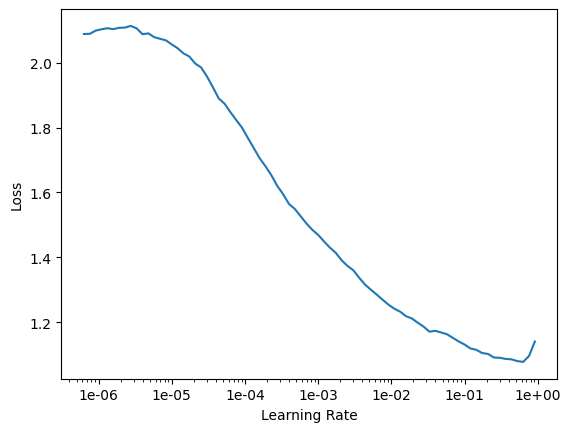

In [105]:
learn.lr_find()
learn.recorder.plot()

In [106]:
def unet_splitter(m): return L(m.encoder, m.decoder).map(params)

In [ ]:
learn.fit_one_cycle(5, max_lr = 1e-3, wd = 0.3)

In [108]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(15, max_lr=1e-4, wd=0.3)

In [110]:
learn.save('allbands_filt_hyp_attn_5+15')